## Demo: Distributional Adversarial Networks on a toy dataset

In this notebook, we test the adversarial network methods on a simple a toy dataset consisting of a 2D mixture of gaussians, where traditional single-sample-point methods such as GAN are known to struggle with mode collapse. 

### Import and Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
%matplotlib inline

from IPython import display

In [2]:
# Model configuration
model      = 'dan_s' # One of: [gan,dan_s,dan_2s]
batch_size = 512
Z_dim      = 256

### Generator and Discriminator Networks

In [3]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_h3 = tf.nn.relu(tf.matmul(G_h2, G_W3) + G_b3)
    G_logit = tf.matmul(G_h3, G_W4) + G_b4
    return G_logit

def gan_discriminator(x_real, x_fake):
    """ I.e. Regular GAN discriminator """
    D_h1_real = tf.nn.relu(tf.matmul(x_real / 4, D_W1) + D_b1)
    D_h2_real = tf.nn.relu(tf.matmul(D_h1_real, D_W2) + D_b2)
    D_h3_real = tf.nn.relu(tf.matmul(D_h2_real, D_W3) + D_b3)
    D_logit_real = tf.matmul(D_h3_real, D_W4) + D_b4
    D_prob_real = tf.nn.sigmoid(D_logit_real)

    D_h1_fake = tf.nn.relu(tf.matmul(x_fake / 4, D_W1) + D_b1)
    D_h2_fake = tf.nn.relu(tf.matmul(D_h1_fake, D_W2) + D_b2)
    D_h3_fake = tf.nn.relu(tf.matmul(D_h2_fake, D_W3) + D_b3)
    D_logit_fake = tf.matmul(D_h3_fake, D_W4) + D_b4
    D_prob_fake = tf.nn.sigmoid(D_logit_fake)    
    return D_prob_real, D_logit_real, D_prob_fake, D_logit_fake

def dan_s_discriminator(x_real, x_fake):
    """ A.k.a Sample classifier for DAN_S"""
    D_h1_real = tf.nn.relu(tf.matmul(x_real / 4, D_W1) + D_b1)
    D_h2_real = tf.reduce_mean(tf.nn.relu(tf.matmul(D_h1_real, D_W2) + D_b2), axis=0, keep_dims=True)
    D_h3_real = tf.nn.relu(tf.matmul(D_h2_real, D_W3) + D_b3)
    D_logit_real = tf.matmul(D_h3_real, D_W4) + D_b4
    D_prob_real = tf.nn.sigmoid(D_logit_real)

    D_h1_fake = tf.nn.relu(tf.matmul(x_fake / 4, D_W1) + D_b1)
    D_h2_fake = tf.reduce_mean(tf.nn.relu(tf.matmul(D_h1_fake, D_W2) + D_b2), axis=0, keep_dims=True)
    D_h3_fake = tf.nn.relu(tf.matmul(D_h2_fake, D_W3) + D_b3)
    D_logit_fake = tf.matmul(D_h3_fake, D_W4) + D_b4
    D_prob_fake = tf.nn.sigmoid(D_logit_fake)

    return D_prob_real, D_logit_real, D_prob_fake, D_logit_fake
                        
def dan_2s_discriminator(x_ori_1, x_ori_2, x_alter_1, x_alter_2):
    """ A.k.a two-sample discriminator"""
    D_h1_ori_1 = tf.nn.relu(tf.matmul(x_ori_1 / 4, D_W1) + D_b1)
    D_h2_ori_1 = tf.reduce_mean(tf.nn.relu(tf.matmul(D_h1_ori_1, D_W2) + D_b2), axis=0, keep_dims=True)
    D_h1_alter_1 = tf.nn.relu(tf.matmul(x_alter_1 / 4, D_W1) + D_b1)
    D_h2_alter_1 = tf.reduce_mean(tf.nn.relu(tf.matmul(D_h1_alter_1, D_W2) + D_b2), axis=0, keep_dims=True)
    D_h1_ori_2 = tf.nn.relu(tf.matmul(x_ori_2 / 4, D_W1) + D_b1)
    D_h2_ori_2 = tf.reduce_mean(tf.nn.relu(tf.matmul(D_h1_ori_2, D_W2) + D_b2), axis=0, keep_dims=True)
    D_h1_alter_2 = tf.nn.relu(tf.matmul(x_alter_2 / 4, D_W1) + D_b1)
    D_h2_alter_2 = tf.reduce_mean(tf.nn.relu(tf.matmul(D_h1_alter_2, D_W2) + D_b2), axis=0, keep_dims=True)

    D_h3_11 = tf.nn.relu(tf.matmul(tf.abs(D_h2_ori_2 - D_h2_ori_1), D_W3) + D_b3)
    D_h3_10 = tf.nn.relu(tf.matmul(tf.abs(D_h2_ori_2 - D_h2_alter_1), D_W3) + D_b3)
    D_h3_01 = tf.nn.relu(tf.matmul(tf.abs(D_h2_alter_2 - D_h2_ori_1), D_W3) + D_b3)
    D_h3_00 = tf.nn.relu(tf.matmul(tf.abs(D_h2_alter_2 - D_h2_alter_1), D_W3) + D_b3)

    D_logit_00 = tf.matmul(D_h3_00, D_W4) + D_b4
    D_logit_01 = tf.matmul(D_h3_01, D_W4) + D_b4
    D_logit_10 = tf.matmul(D_h3_10, D_W4) + D_b4
    D_logit_11 = tf.matmul(D_h3_11, D_W4) + D_b4
    return D_logit_00, D_logit_11, D_logit_01, D_logit_10


### Utility functions

In [12]:
def sample_Z(m, n):
    return np.random.normal(size=[m, n])

def read():
    fid = open('gaussian.txt', 'r')
    lines = fid.readlines()
    data = []
    for line in lines:
        data.append([float(curr_num) for curr_num in line.split()])
    return np.array(data)

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

# def sample_mog(n_points, n_mixture=8, std=0.01, radius=1.0):
#     thetas = np.linspace(0, 2 * np.pi, n_mixture)
#     xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
#     cat = tf.contrib.distributions.Categorical(tf.zeros(n_mixture))
#     comps = [tf.contrib.distributions.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
#     data = tf.contrib.distributions.Mixture(cat, comps)
#     return data.sample(n_points)


### Declare variables

In [5]:
# Set up weights
D_W1 = tf.Variable(xavier_init([2, 32]))
D_b1 = tf.Variable(tf.zeros(shape=[32]))

D_W2 = tf.Variable(xavier_init([32, 32]))
D_b2 = tf.Variable(tf.zeros(shape=[32]))

D_W3 = tf.Variable(xavier_init([32, 32]))
D_b3 = tf.Variable(tf.zeros(shape=[32]))

D_W4 = tf.Variable(xavier_init([32, 1]))
D_b4 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3, D_W4, D_b4]

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 128]))
G_b2 = tf.Variable(tf.zeros(shape=[128]))

G_W3 = tf.Variable(xavier_init([128,128]))
G_b3 = tf.Variable(tf.zeros(shape=[128]))

G_W4 = tf.Variable(xavier_init([128, 2]))
G_b4 = tf.Variable(tf.zeros(shape=[2]))

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3, G_W4, G_b4]

In [6]:
# Set up variables
if model in ['gan', 'dan_s']:
    # Only one sample in this case
    X = tf.placeholder(tf.float32, shape=[None, 2])
    Z = tf.placeholder(tf.float32, shape=[None, Z_dim])    
    G_sample = generator(Z)    
    if model == 'gan':
        D_prob_real, D_logit_real, D_prob_fake, D_logit_fake = gan_discriminator(X, G_sample)    
    else:
        D_prob_real, D_logit_real, D_prob_fake, D_logit_fake = dan_s_discriminator(X, G_sample)    
        
else:
    # One variable per sample
    X_1 = tf.placeholder(tf.float32, shape=[None, 2])
    X_2 = tf.placeholder(tf.float32, shape=[None, 2])
    Z_1 = tf.placeholder(tf.float32, shape=[None, Z_dim])
    Z_2 = tf.placeholder(tf.float32, shape=[None, Z_dim])
    G_sample_1 = generator(Z_1)
    G_sample_2 = generator(Z_2)    
    D_logit_00, D_logit_11, D_logit_01, D_logit_10 = dan_2s_discriminator(X_1, X_2, G_sample_1, G_sample_2)


In [7]:
# Set up losses
if model in ['gan', 'dan_s']:
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
else:
    D_loss_00 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_00, labels=tf.zeros_like(D_logit_00)))
    D_loss_01 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_01, labels=tf.ones_like(D_logit_01)))
    D_loss_10 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_10, labels=tf.ones_like(D_logit_10)))
    D_loss_11 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_11, labels=tf.zeros_like(D_logit_11)))
    G_loss_01 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_01, labels=tf.zeros_like(D_logit_01)))
    G_loss_10 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_10, labels=tf.ones_like(D_logit_10)))

    D_loss = D_loss_00 + D_loss_01 + D_loss_10 + D_loss_11
    G_loss = G_loss_01 + G_loss_10

# Set up solvers
D_solver = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5).minimize(G_loss, var_list=theta_G)

### Read Data

In [11]:
data = read()
data_size = len(data)
data_size = 40000
data = np.concatenate((data, data[:batch_size,:]), axis=0)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

save_fig_path = 'out_' + model
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)

i = 0

### Plot ground truth

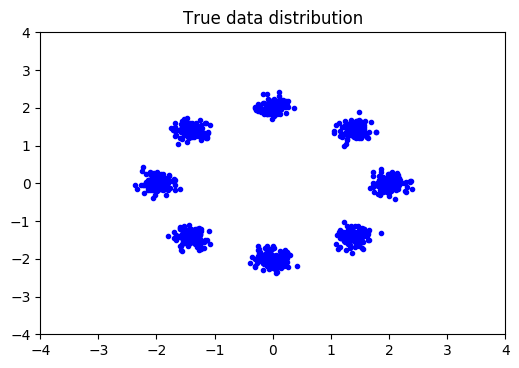

In [13]:
plt.plot(data[:1000,0], data[:1000,1], 'b.')
axes = plt.gca()
axes.set_xlim([-4,4])
axes.set_ylim([-4,4])
plt.title('True data distribution')
plt.savefig(save_fig_path + '/real.png', bbox_inches='tight')

### Train

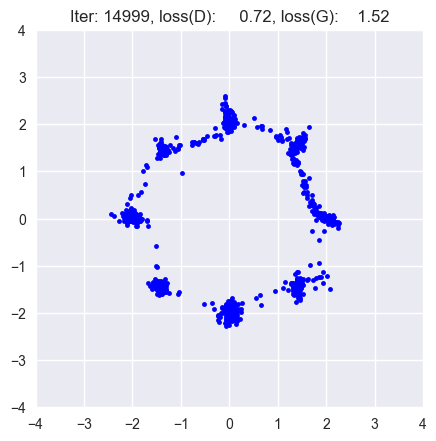

In [ ]:
np_samples = []
plot_every = 5000
plt.figure(figsize=(5,5))

for it in range(30000):
    start_idx = it*batch_size%data_size
    X_mb = data[start_idx:start_idx+batch_size, :]

    if model in ['gan', 'dan_s']:
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(batch_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: sample_Z(batch_size, Z_dim)})
    else:
        sample_size = int(batch_size/2)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X_1: X_mb[:sample_size,:], \
                                    X_2: X_mb[sample_size:,:], \
                                    Z_1: sample_Z(sample_size, Z_dim), \
                                    Z_2: sample_Z(sample_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={ \
                                    X_1: X_mb[:sample_size,:], \
                                    X_2: X_mb[sample_size:,:], \
                                    Z_1: sample_Z(sample_size, Z_dim), \
                                    Z_2: sample_Z(sample_size, Z_dim)})            

    if (it+1) % plot_every == 0:
        if model in ['gan', 'dan_s']:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(1000, Z_dim)})
        else:
            samples = sess.run(G_sample_1, feed_dict={Z_1: sample_Z(1000, Z_dim)})

        np_samples.append(samples)
        plt.clf()
        plt.plot(samples[:,0], samples[:,1], 'b.')
        axes = plt.gca()
        axes.set_xlim([-4,4])
        axes.set_ylim([-4,4])
        plt.title('Iter: {}, loss(D): {:8.2f}, loss(G):{:8.2f}'.format(it, D_loss_curr, G_loss_curr))
        plt.savefig('out_' + model + '/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')        
        display.display(plt.gcf()) 
        display.clear_output(wait=True)
        i += 1


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


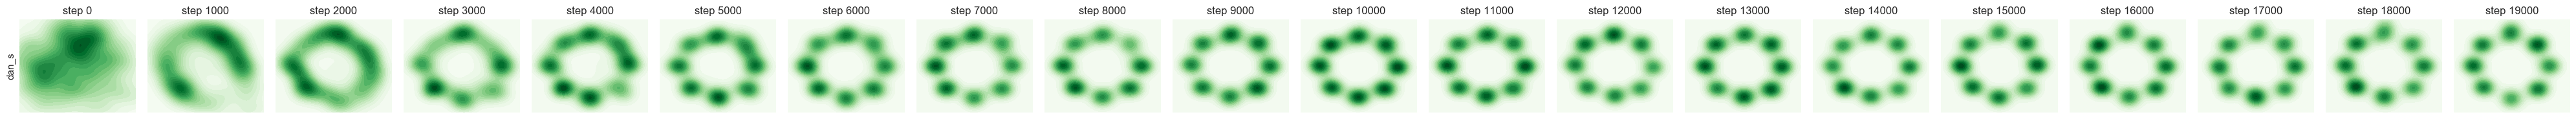

In [27]:
import seaborn as sns
xmax = 3

np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
plt.figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = plt.subplot(1,cols,1)
    else:
        plt.subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-xmax,xmax]]*2)
    ax2.set_facecolor(bg_color)
    plt.xticks([]); plt.yticks([])
    plt.title('step %d'%(i*plot_every))
ax.set_ylabel('%s'% model)
plt.gcf().tight_layout()